In [1]:
from IPython.display import display

from sympy import *
init_printing()

from monom import *

In [2]:
t, x, tau, h, k = symbols(r't, x, tau, h, k', real=True)
u = symbols('u', cls=Function)(t, x)

In [74]:
pda_f, pda_v = (u,), (t, x)
pda_n, pda_clp = 7, 5
pda_p = Rational(0, 1), Rational(0, 1)

In [4]:
Monom.variables = 1 + len(pda_v)
Monom.cmp = Monom.TOPdeglex
Monom.zero = Monom(0 for v in range(Monom.variables))
pda_fun = dict(zip(pda_f,\
             (Monom(0 if v else i for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))
pda_var = dict(zip(pda_v,\
             (Monom(0 if v != i else 1 for v in range(Monom.variables))\
              for i in range(1, Monom.variables))))

In [5]:
def T(f, j1, k1):
    return sum(sum(\
        diff(f, t, j, x, k)*(tau*(j1+pda_p[0]))**j\
                             *(h*(k1+pda_p[1]))**k/\
               (factorial(j)*factorial(k))\
               for k in range(pda_n-j)) for j in range(pda_n))

In [67]:
def clip(f):
    f = f.expand()
    return [f.coeff(h, i) for i in range(pda_clp)]

def df2m(a):
    assert a.func == Derivative
    m = pda_fun[a.args[0]]
    for xi in a.args[1:]:
        if isinstance(xi, Symbol):
            m = m*pda_var[xi]
        else:
            m = m*pda_var[xi[0]]**xi[1]
    return m

def m2df(m):
    r = pda_f[m[0]-1]
    for i in range(1, len(m)):
        r = r.diff(pda_v[i-1], m[i])
    return r

def findDiv(a, d):
    r = None
    def find(a, r):
        if a.args:
            if a.func == Derivative and a.args[0] in pda_fun:
                m = df2m(a)
                if m.divisible(d) and (not r or m.cmp(r) > 0):
                    r = m
            else:
                for s in a.args:
                    r = find(s, r)
        return r
    return find(a, r)

def reduction(f1, f2, m, c, shift):
    assert shift < pda_clp
    r = [f1[i] for i in range(shift)]
    if not m:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift]*c))
    else:
        for i in range(shift, pda_clp):
            r.append(expand(f1[i] - f2[i-shift].diff(*m)*c))
    return r

def NF(f, df, G):
    assert len(df) == len(G)
#     print(df2m(df[0]))
    ms = [df2m(d) for d in df]
    for i in range(1, pda_clp):
        t = 0
        if f[i]:
            while True:
                r = None
                for l in range(len(ms)):
                    r = findDiv(f[i], ms[l])
                    if r:
                        break
                if not r: 
                    break
                c, deg, m = 0, 7, m2df(r)
                while c == 0:
                    c = f[i].coeff(m, deg)
                    deg -= 1
                    assert deg >= 0
#                 print(c, m, deg+1)
                if deg:
                    c *= m**deg
                m = r/ms[l]
                d = []
                for k in range(len(pda_v)):
                    if m[k+1] > 0:
                        d.append(pda_v[k])
                        if m[k+1] > 1:
                            d.append(m[k+1])
                f = reduction(f, G[l], tuple(d), c, i)
                t += 1
#                 if t > 6: break
    return f

def compact(f):
    def cmpct(a):
        if not a.args:
            return a
        else:
            if a in pda_fun:
                return Symbol("%s" % a.func, real=True)
            elif a.func == Derivative and a.args[0] in pda_fun:
                m = []
                for xi in a.args[1:]:
                    if isinstance(xi, Symbol):
                        m.append(str(xi))
                    else:
                        m.append(str(xi[0])*xi[1])
                return Symbol("%s_{%s}" % (a.args[0].func, "".join(m)), real=True)
            else:
                return a.func(*tuple(cmpct(s) for s in a.args))
    return [cmpct(a) for a in f]

The KdV equation is often written in a slightly different form, e.g.,
\begin{equation}
\partial_t u + \alpha u \partial_x u  + \beta \partial_x^3 u = 0 \tag{1.18}
\end{equation}

In [49]:
# a, b = symbols(r'alpha beta', real=True)
a, b = 6, 1

we explicit scheme with $O(\tau^2, h^2)$ approximation:
\begin{align}
 u^{n+1}_{i} =& u^{n-1}_{i} -\dfrac{\alpha \tau}{h}u^{n}_{i}\left(u^{n}_{i+1} - u^{n}_{i-1}\right)\\
 & - \dfrac{\beta \tau}{h^3}\left(u^{n}_{i+2} - 2u^{n}_{i+1} + 2u^{n}_{i-1} - u^{n}_{i-2}\right) \tag{1.80}
\end{align}

for sufficiently small steps
\begin{equation}
\tau  \leq \dfrac{2h^3}{3\sqrt{3}\beta} \cong 0.384\dfrac{h^3}{\beta} \tag{1.81}
\end{equation}

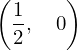

In [50]:
pda_p = Rational(1, 2), Rational(0, 1)
pda_p

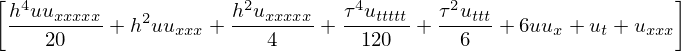

In [80]:
series = expand((T(u, 1, 0) - T(u, -1, 0))/(2*tau) +\
a/(2*h)*(T(u, 0, 0)*(T(u, 0, 1) - T(u, 0, -1))) +\
b/(2*h**3)*(T(u, 0, 2) - 2*T(u, 0, 1) + 2*T(u, 0, -1) - T(u, 0, -2)))
compact([series])

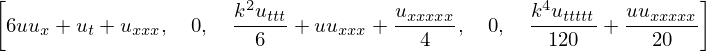

In [76]:
eq = clip(series.subs({tau: k*h}))
compact(eq)

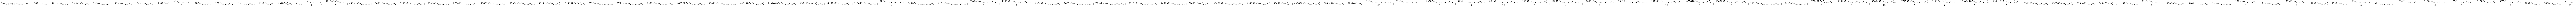

In [77]:
compact(NF(eq, [u.diff(t, 1)], [eq]))

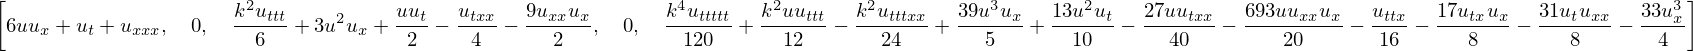

In [78]:
compact(NF(eq, [u.diff(x, 3)], [eq]))

In [25]:
u.func

u

In [42]:
pda_f[0].func

u